#### exporta atributos geometricos em csv 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import segyio
from pandas import DataFrame

In [2]:
path = input('path do arquivo: ')
if path == '':
    path = '/home/claudio/dados/BR/sgy/envelop/'    
exten = input('extensão: ')
if exten == '':
    exten = '.sgy'
name = input('Nome do arquivo: ')
if name  == '':
    #name = 'TUP188.08@R00172A' - nao envelopado
    #name = 'TUP188.08@R00145A'
    #name = 'TUP188.08@R00232A'
    #name = 'TUP188.08@R00317_2'
    #name = 'TUP188.08@R00402_2'
    #name = 'TUP188.08@R00372A'
    #name = 'TUP188.08@R00293A'  # o menor arquivo
    #name = '127a.1.a.0.et.subb'
    #name = '147.1.a.0.et.subb'
    #name = '147.1.a.0.et.subbimg2' - erro: trace lengths possibly of non-uniform
    #name = '147.1.a.0.et.subbdrv1' - erro - idem
    #name = '102 CATUA_2_part-02'
    #name = '102 CATUA_1_part-03'
    #name = 'ARU231.10@R00071'
    name = 'ARU231.10@R00187A'
    #name = 'IRC152.06@R00085A_1'
    #name = 'IRC152.06@R00115A'
    #name = 'IRC152.06@R00111A_2'

filename = path + name + exten
print('Arquivo: ',filename)

path do arquivo: 
extensão: 
Nome do arquivo: 
Arquivo:  /home/claudio/dados/BR/sgy/envelop/ARU231.10@R00187A.sgy


In [3]:
with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) /1000000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    sr = sample_rate
    fr = segyio.TraceField.FieldRecord
    rec_num = f.attributes(fr)[:]  # array of field record number

print(f'Num Traces: {n_traces}, Num Samples: {n_samples}, Sample rate: {sample_rate} s, Trace length: {max(twt)} ms')

Num Traces: 3424, Num Samples: 6212, Sample rate: 4.6e-05 s, Trace length: 285.706 ms


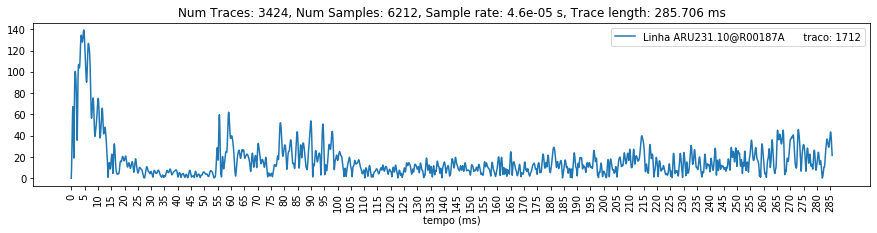

In [4]:
plt.figure(figsize=(15,3))

tr = int(n_traces/2)  # pega um traco do meio qq para definir janela (opcao: colocar toda a imagem sismica)
n = sample_rate * n_samples * 1000  # xmax em ms
x = np.linspace(0, n, n_samples)  # eixo x
y = data[tr]   # pega o array do traco

num = n//50
interv = np.arange(0, n, num)
plt.xticks(interv, rotation='vertical')
plt.plot(x, y, label=('Linha '+name+'      traco: '+ str(tr)))
plt.xlabel('tempo (ms)')
plt.title(f'Num Traces: {n_traces}, Num Samples: {n_samples}, Sample rate: {sample_rate} s, Trace length: {max(twt)} ms')
plt.legend()
plt.show()

In [5]:
print('******* Definir janela da imagem **********')
print('************ 1 ms = 0.75 m ****************')
tmi = int(input('tempo inicial (ms):'))
tmf = int(input('tempo final (ms):'))
tri = int(input('traco inicial:'))
trf = int(input('traco final:'))


******* Definir janela da imagem **********
************ 1 ms = 0.75 m ****************
tempo inicial (ms):50
tempo final (ms):150
traco inicial:2400
traco final:3400


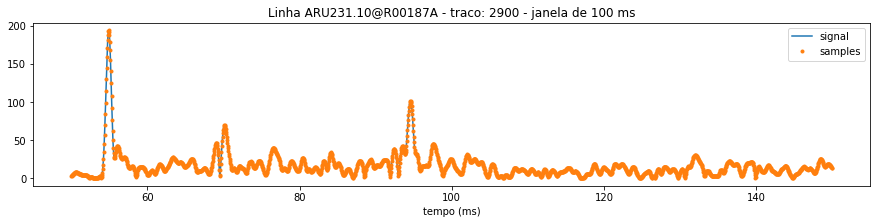

In [6]:
# convertendo ms to samples
spi = int(tmi/sr /1000 )  # amostra inicial
spf = int(tmf/sr /1000 )  # amostra final

sig = data[tri:trf, spi:spf]

tr = (trf - tri)//2 # pega o traco do meio

y = data[tr, spi:spf]   # y sao os dados da janela em samples no traco tr
x = np.linspace(tmi, tmf, len(y))  # eixo x em milisegundos

plt.figure(figsize=(15,3))
plt.xlabel('tempo (ms)')
plt.title('Linha '+name+' - traco: '+ str(tri + tr)+' - janela de '+ str(tmf - tmi)+' ms')
plt.plot(x, y, label=('signal'))
plt.plot(x, y, '.', label=('samples'))
plt.legend()
plt.show()

In [7]:
time = []
n_spike = []
n_traco = []
larg_esq = []
larg_dir = []
alt_esq = []
alt_dir = []
area_esq = []
area_dir = []
ratio_esq = []
ratio_dir = []
grad_esq = []
grad_dir = []
assim = []
ang_spike = []
raz_abert_area = []
raz_abert_alt = []
ratio_areas = []
dif_areas = []


In [8]:
trc = -1  


for tr in range(tri, trf):
    
    sig_1t = data[tr, spi:spf]   # dados da janela em samples em cada traco 
    x = np.arange(len(sig_1t))
    
    peaks, properties = find_peaks(sig_1t)  # encontra o x de todos os peaks    

    trc += 1   # contador de tracos
    incr = 0   # contador de spikes
    
    ymins = []
    xmins = []
    ymin = 1e6
    
    for ip in range(peaks.size-1):  # calcula os minimos entre peaks

        i1 = int(x[peaks[ip]])
        i2 = int(x[peaks[ip+1]])

        for im in range(i1, i2):

            if sig_1t[im] < ymin:
                ymin = sig_1t[im]
                xmin = x[im]                

        ymins.append(ymin)  # salva os minimos no intervalo entre 2 peaks
        xmins.append(xmin)
        
        ymin = 1e6

        

    for id in range(len(xmins)):    


        dx1 = xmins[id] - x[peaks[id]]
        larg_esq.append(dx1)

        dy1 = sig_1t[peaks[id]] - ymins[id]
        alt_esq.append(dy1)

        dx2 = x[peaks[id+1]] - xmins[id] 
        larg_dir.append(dx2)

        dy2 = sig_1t[peaks[id+1]] - ymins[id]
        alt_dir.append(dy2)

        #=====================================

        aesq = (dx1*dy1)/2  # area a esquerda
        area_esq.append(aesq)

        adir = (dx2*dy2)/2 # area a direita 
        area_dir.append(adir)

        # relacao base x altura (ratio)
        ratio_esq.append(dx1/dy1)
        ratio_dir.append(dx2/dy2)

        # gradientes
        grad_esq.append(np.arctan2(dy1, dx1) * 180 / np.pi)
        grad_dir.append(np.arctan2(dy2, dx2) * 180 / np.pi)
        
        # angulo to topo dos spikes
        ge = np.arctan2(dy1, dx1) * 180 / np.pi
        gd = np.arctan2(dy2, dx2) * 180 / np.pi
        ang = (90 - ge) + (90 - gd)
        ang_spike.append(ang)
        
        # razao angulo total / area total
        raz_ang_area = ang / (aesq + adir)
        raz_abert_area.append(raz_ang_area)
        
        # razao angulo total / altura
        raz_ang_alt = ang / ((dy1 + dy2) / 2)
        raz_abert_alt.append(raz_ang_alt)        
        
        # razao entre areas esq e dir
        raz_areas = aesq / adir
        ratio_areas.append(raz_areas)
        
        # diferenca entre as areas
        
        dif_ar = aesq - adir
        dif_areas.append(dif_ar)     
        
        # assimetria
        if adir > aesq:
            assim.append(1)
        else:
            assim.append(0)

        n_spike.append(incr)
        incr += 1         # contador de spikes

        t = peaks[id]*sr*1000 + tmi  # samples to ms
        time.append(t)   

        n_traco.append(trc) #  numerador de tracos
        
    # ==================================  
    


In [9]:
D = {'n_traco': n_traco,'n_spike': n_spike,'time': time,'larg_esq': larg_esq,'alt_esq': alt_esq,
     'larg_dir':larg_dir, 'alt_dir': alt_dir, 'area_esq': area_esq,'area_dir': area_dir,
     'ratio_esq': ratio_esq,'ratio_dir': ratio_dir,'grad_esq': grad_esq,'grad_dir': grad_dir,
     'assim 0=esq 1 = dir': assim, 'ang_spike': ang_spike, 'raz_abert/area': raz_abert_area, 
     'raz_abert/alt': raz_abert_alt, 'ratio_areas': ratio_areas, 'dif_areas': dif_areas}

df = DataFrame(D, columns= ['n_traco', 'n_spike', 'time', 'larg_esq', 'alt_esq', 'larg_dir', 'alt_dir',
                            'area_esq', 'area_dir', 'ratio_esq','ratio_dir', 'grad_esq', 'grad_dir', 
                            'assim 0=esq 1 = dir', 'ang_spike', 'raz_abert/area', 'raz_abert/alt',
                            'ratio_areas', 'dif_areas'])

f = path+name+'_atrib_geom.csv'
export_csv = df.to_csv (f, index = None, header=True) 
print('finish')

finish


In [11]:
ang_spike.

AttributeError: 'list' object has no attribute 'max'